**导入**

In [ ]:
import sys

sys.path.append("src/")

In [ ]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

import config, dataset, main, utils, bins

In [ ]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

In [ ]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

**数据读取**

In [ ]:
instance1_para = pd.read_csv("mydf1_para.csv")  # 货箱的初始维度：最长边与托盘高平行，次长边与托盘长平行，最短边与托盘宽平行

instance1_para.head()

In [ ]:
instance1 = pd.read_csv("mydf1.csv")  # 分布符合初始维度较好参数

instance1.head()

*分布符合初始维度较好参数*

<IPython.core.display.Javascript object>


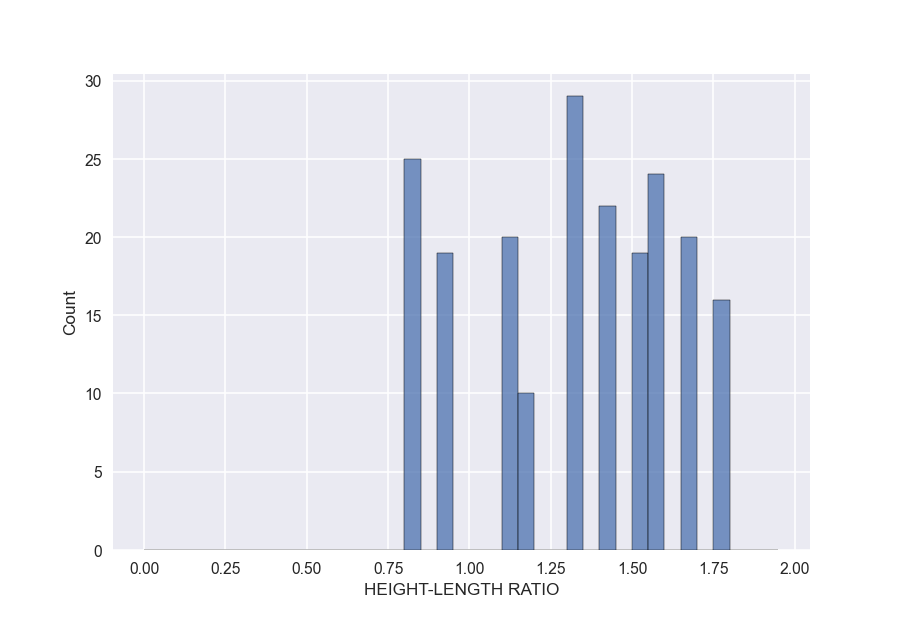

<IPython.core.display.Javascript object>

In [37]:
plt.figure()
axH = sns.histplot(
    instance1.height / instance1.width,
    bins=np.arange(0, 2, 0.05),
)
axH.set(xlabel="HEIGHT-LENGTH RATIO")
plt.show()

<IPython.core.display.Javascript object>


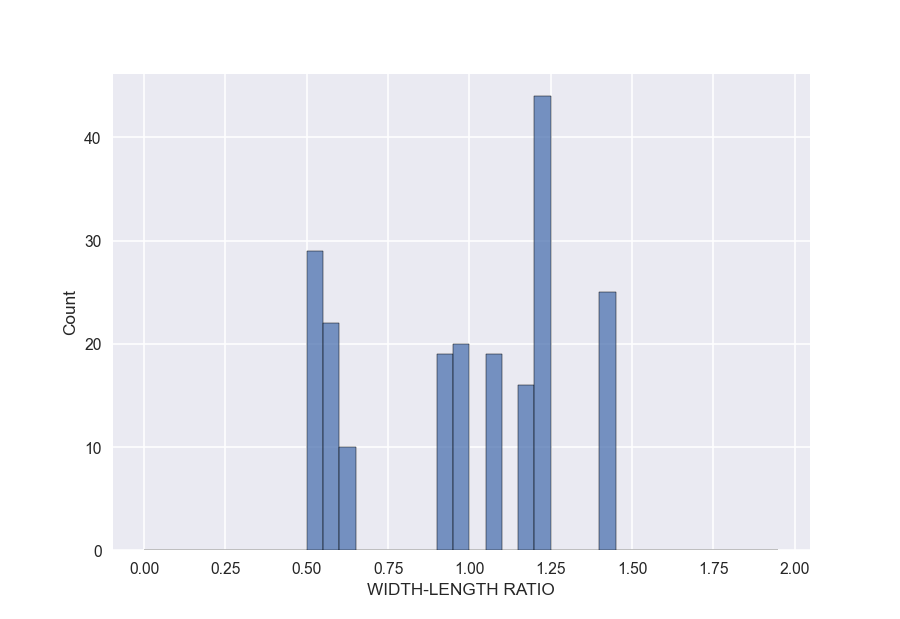

<IPython.core.display.Javascript object>

In [38]:
plt.figure()
axW = sns.histplot(
    instance1.depth / instance1.width,
    bins=np.arange(0, 2, 0.05),
)
axW.set(xlabel="WIDTH-LENGTH RATIO")
plt.show()

<IPython.core.display.Javascript object>


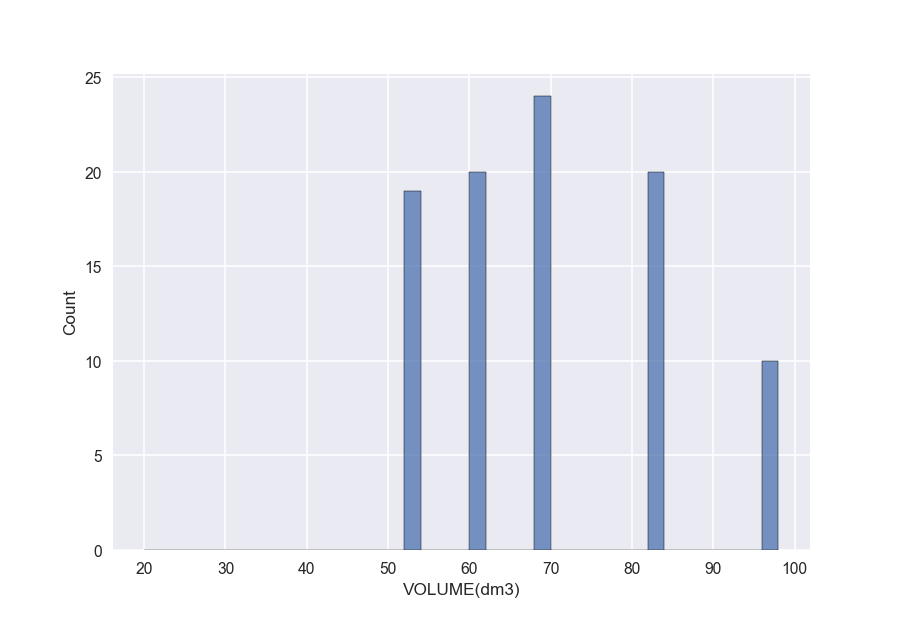

<IPython.core.display.Javascript object>

In [39]:
plt.figure()
axV = sns.histplot(instance1.volume / 1e6, bins=np.arange(20, 100, 2))
axV.set(xlabel="VOLUME(dm3)")
plt.show()

**旋转扰动**

*30%Y*

In [ ]:
def swap_values(group):
    n_samples = int(
        len(group) * 0.3
    )  # calculate number of samples based on 30% threshold
    idx_samples = group.sample(n_samples).index  # select random indices from the group
    group.loc[idx_samples, ["width", "height"]] = group.loc[
        idx_samples, ["height", "width"]
    ].values  # exchange values of selected items
    return group


# group the data by `id` column and apply the `swap_values()` function
instance1_ry3_g = instance1.groupby("id").apply(swap_values)
instance1_ry3 = instance1_ry3_g.reset_index(drop=True)

# print the results
print(instance1_ry3)

<IPython.core.display.Javascript object>


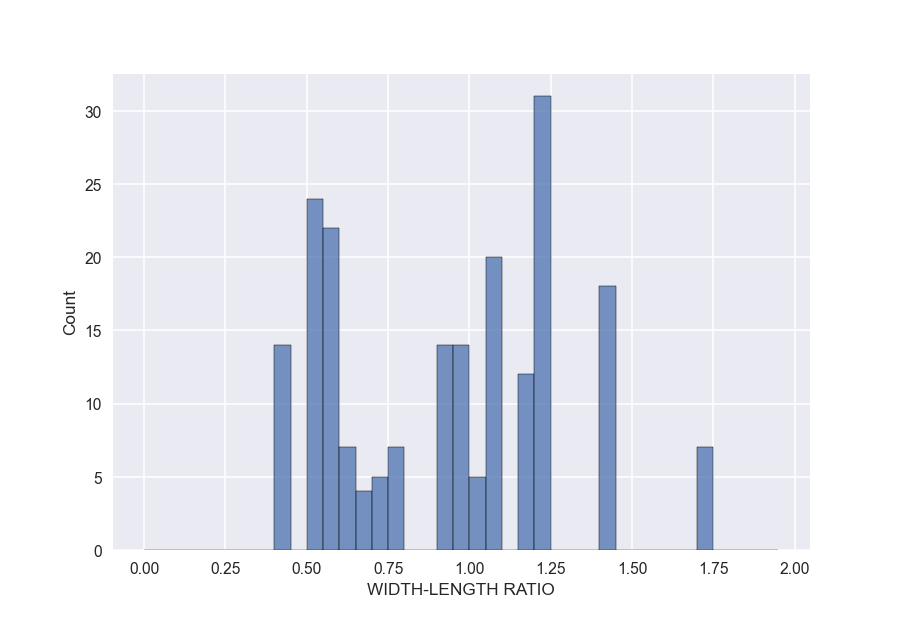

<IPython.core.display.Javascript object>

In [40]:
plt.figure()
axW3 = sns.histplot(
    instance1_ry3.depth / instance1_ry3.width,
    bins=np.arange(0, 2, 0.05),
)
axW3.set(xlabel="WIDTH-LENGTH RATIO")
plt.show()

<IPython.core.display.Javascript object>


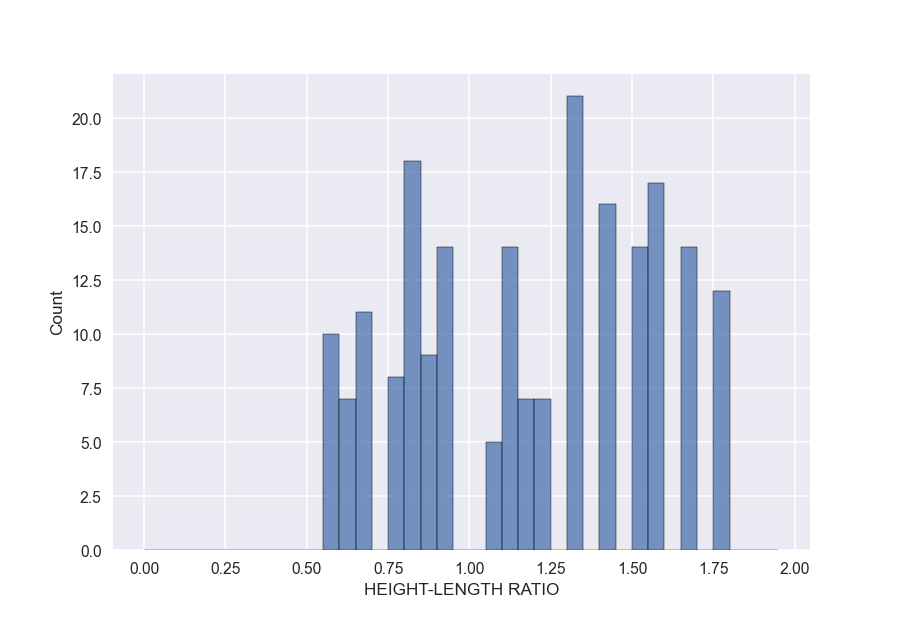

<IPython.core.display.Javascript object>

In [41]:
plt.figure()
axH3 = sns.histplot(
    instance1_ry3.height / instance1_ry3.width,
    bins=np.arange(0, 2, 0.05),
)
axH3.set(xlabel="HEIGHT-LENGTH RATIO")
plt.show()

*50%Y*

In [31]:
perc = 0.5


def swap_values(group):
    n_samples = int(
        len(group) * perc
    )  # calculate number of samples based on 30% threshold
    idx_samples = group.sample(n_samples).index  # select random indices from the group
    group.loc[idx_samples, ["width", "height"]] = group.loc[
        idx_samples, ["height", "width"]
    ].values  # exchange values of selected items
    return group


# group the data by `id` column and apply the `swap_values()` function
instance1_ry5_g = instance1.groupby("id").apply(swap_values)
instance1_ry5 = instance1_ry5_g.reset_index(drop=True)

# print the results
print(instance1_ry5)

               id  width  depth  height      weight      volume
0     78932584178  590.0  320.0   510.0  141.153204  96288000.0
1     78932584178  590.0  320.0   510.0  141.153204  96288000.0
2     78932584178  510.0  320.0   590.0  141.153204  96288000.0
3     78932584178  510.0  320.0   590.0  141.153204  96288000.0
4     78932584178  510.0  320.0   590.0  141.153204  96288000.0
..            ...    ...    ...     ...         ...         ...
199  916526727508  700.0  290.0   490.0    0.157856  99470000.0
200  916526727508  700.0  290.0   490.0    0.157856  99470000.0
201  916526727508  490.0  290.0   700.0    0.157856  99470000.0
202  916526727508  700.0  290.0   490.0    0.157856  99470000.0
203  916526727508  700.0  290.0   490.0    0.157856  99470000.0

[204 rows x 6 columns]


<IPython.core.display.Javascript object>

**装箱运算**

*0%Y*

In [ ]:
bin_pool_npt = main.main(
    instance1,
    procedure="mr",
    superitems_horizontal=False,
    superitems_max_vstacked=2,
    superitems_horizontal_type="two-width",
)
bin_pool_npt.get_original_layer_pool().to_dataframe()
# really banned horizontal

In [ ]:
num_compact_bins_npt = bin_pool_npt.compact_bins_num
print("Number of bins used:", num_compact_bins_npt)

In [ ]:
bin_pool_npt.get_original_bin_pool().describe()

In [ ]:
bin_pool_npt.get_original_layer_pool().describe()

In [ ]:
bin_pool_npt.get_original_bin_pool().plot()

*30%Y*

In [ ]:
bin_pool_ry3 = main.main(
    instance1_ry3,
    procedure="mr",
    superitems_horizontal=False,
    superitems_max_vstacked=2,
    superitems_horizontal_type="two-width",
)
bin_pool_ry3.get_original_layer_pool().to_dataframe()


In [ ]:
num_compact_bins_ry3 = bin_pool_ry3.compact_bins_num
print("Number of bins used:", num_compact_bins_ry3)

In [ ]:
bin_pool_ry3.get_original_bin_pool().describe()

In [ ]:
bin_pool_ry3.get_original_layer_pool().describe()

*50%Y*

In [32]:
bin_pool_ry5 = main.main(
    instance1_ry5,
    procedure="mr",
    superitems_horizontal=False,
    superitems_max_vstacked=2,
    superitems_horizontal_type="two-width",
)
bin_pool_ry5.get_original_layer_pool().to_dataframe()


2023-05-26 13:47:53.459 | INFO     | main:main:174 - MR procedure starting
2023-05-26 13:47:53.460 | INFO     | main:main:184 - MR iteration 1/1
2023-05-26 13:47:53.488 | DEBUG    | superitems:_gen_single_items_superitems:674 - Generated 204 superitems with a single item
2023-05-26 13:47:53.489 | INFO     | superitems:gen_superitems:629 - Generating vertical superitems with maximum stacking of 2
2023-05-26 13:47:53.494 | DEBUG    | superitems:_gen_superitems_vertical:833 - Generated 63 wide vertical superitems
2023-05-26 13:47:53.498 | DEBUG    | superitems:_gen_superitems_vertical:835 - Generated 37 deep vertical superitems
2023-05-26 13:47:53.500 | INFO     | superitems:gen_superitems:633 - Generated 304 superitems
2023-05-26 13:47:53.504 | INFO     | superitems:gen_superitems:635 - Remaining superitems after filtering by pallet dimensions: 304
2023-05-26 13:47:53.509 | INFO     | main:maxrects_warm_start:44 - MR computing layers
2023-05-26 13:47:53.510 | INFO     | main:maxrects_war

2023-05-26 13:47:55.942 | DEBUG    | maxrects:maxrects_single_layer_offline:124 - MR-SL-Offline generated a new layer with 5 superitems and 0.5513626834381551 3D density
2023-05-26 13:47:55.944 | DEBUG    | maxrects:maxrects_single_layer_offline:88 - MR-SL-Offline starting
2023-05-26 13:47:55.945 | DEBUG    | maxrects:maxrects_single_layer_offline:94 - MR-SL-Offline [0 1 2 3 4]/5 superitems to place
2023-05-26 13:47:55.947 | DEBUG    | maxrects:maxrects_single_layer_offline:124 - MR-SL-Offline generated a new layer with 5 superitems and 0.5513626834381551 3D density
2023-05-26 13:47:55.959 | DEBUG    | layers:filter_layers:506 - Remaining 21 layers after removing duplicated items
2023-05-26 13:47:55.962 | DEBUG    | layers:filter_layers:508 - Remaining 21 layers after removing the empty ones
2023-05-26 13:47:55.974 | INFO     | main:main:237 - Items not covered: 41/204
2023-05-26 13:47:56.091 | DEBUG    | maxrects:maxrects_single_layer_online:138 - MR-SL-Online starting
2023-05-26 13:4

,item,x,y,z,width,depth,height,layer
0,72,0,0,0,700,290,530,0
1,70,0,0,530,700,290,530,0
2,96,0,290,0,700,290,530,0
3,71,0,290,530,700,290,530,0
4,35,700,0,0,460,460,500,0
...,...,...,...,...,...,...,...,...
199,3,490,720,0,510,320,590,28
200,6,330,0,0,510,320,590,28
201,76,0,0,0,530,290,700,29
202,197,530,0,0,490,290,700,29


<IPython.core.display.Javascript object>

In [33]:
num_compact_bins_ry5 = bin_pool_ry5.compact_bins_num
print("Number of bins used:", num_compact_bins_ry5)

Number of bins used: 16


<IPython.core.display.Javascript object>

In [ ]:
bin_pool_ry5.get_original_bin_pool().describe()

**记录结果**

In [ ]:
bin_pool_npt.plot()

<IPython.core.display.Javascript object>


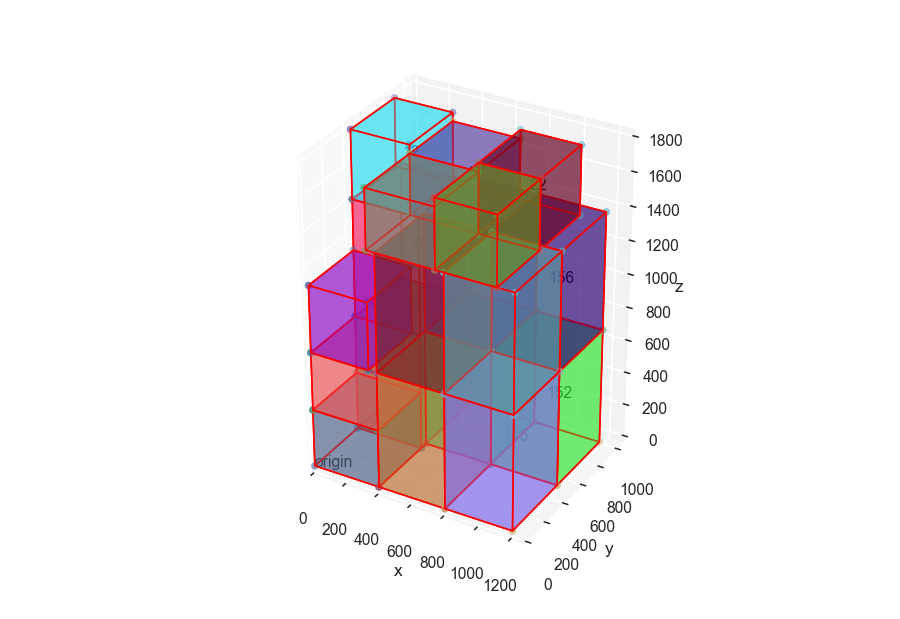

<IPython.core.display.Javascript object>


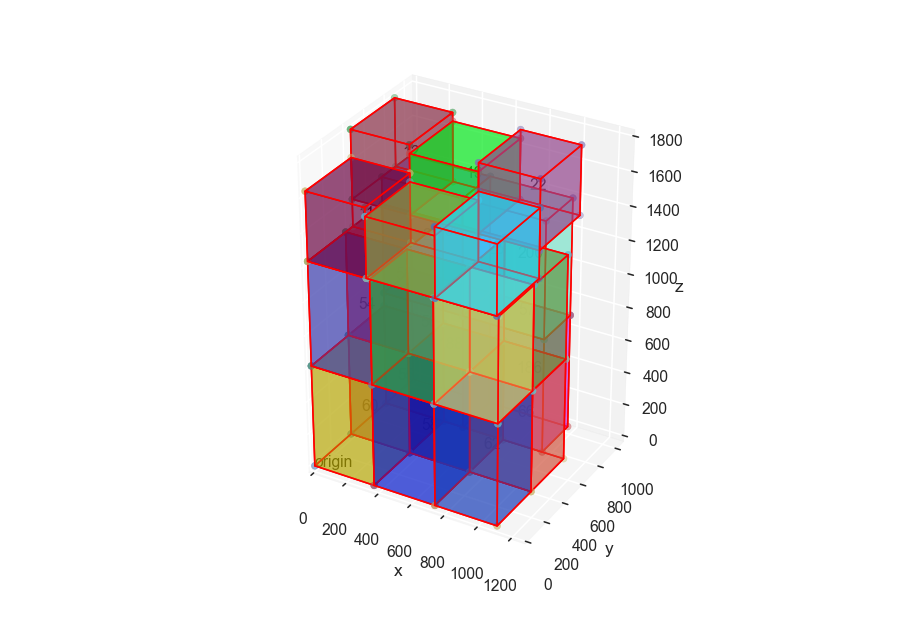

<IPython.core.display.Javascript object>


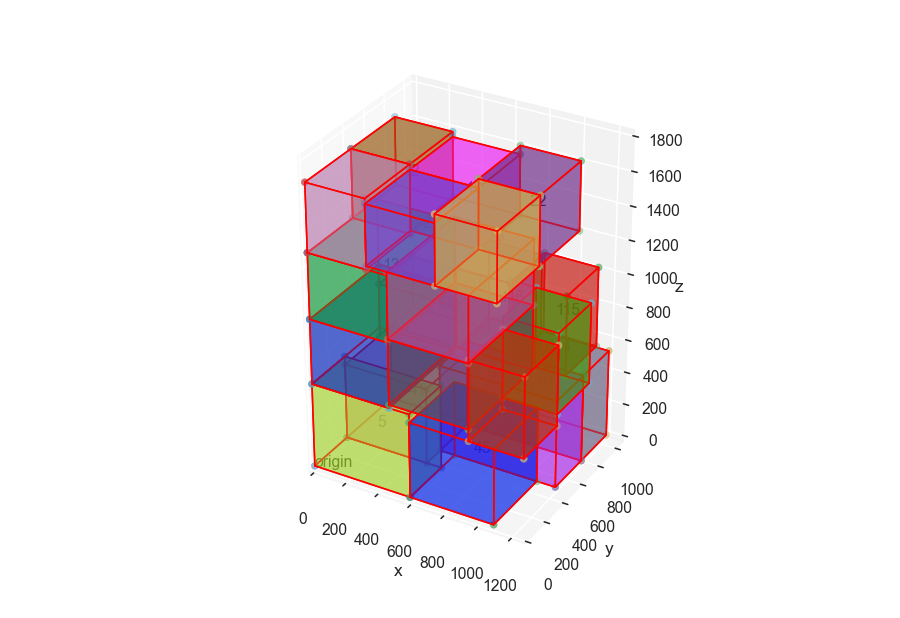

<IPython.core.display.Javascript object>


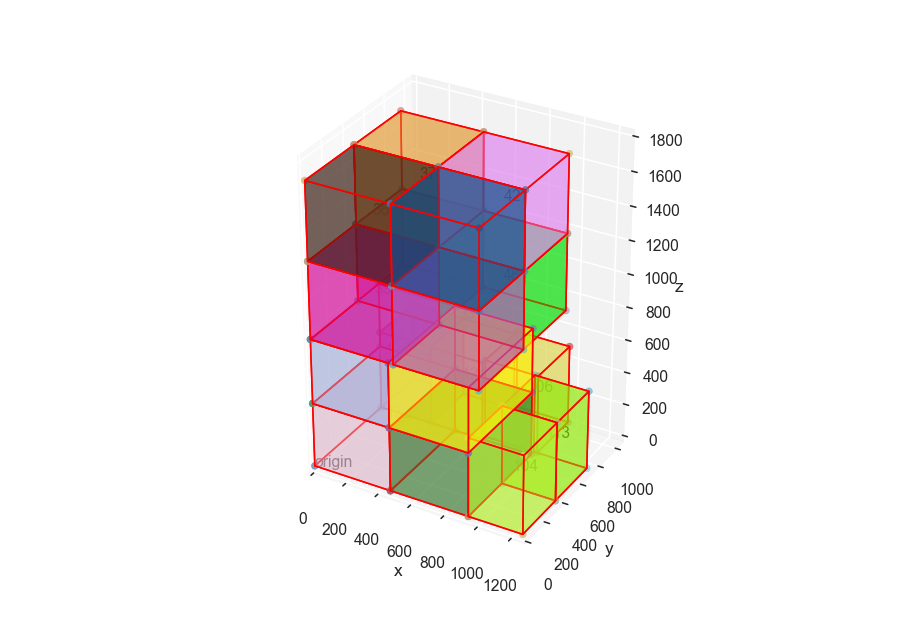

<IPython.core.display.Javascript object>


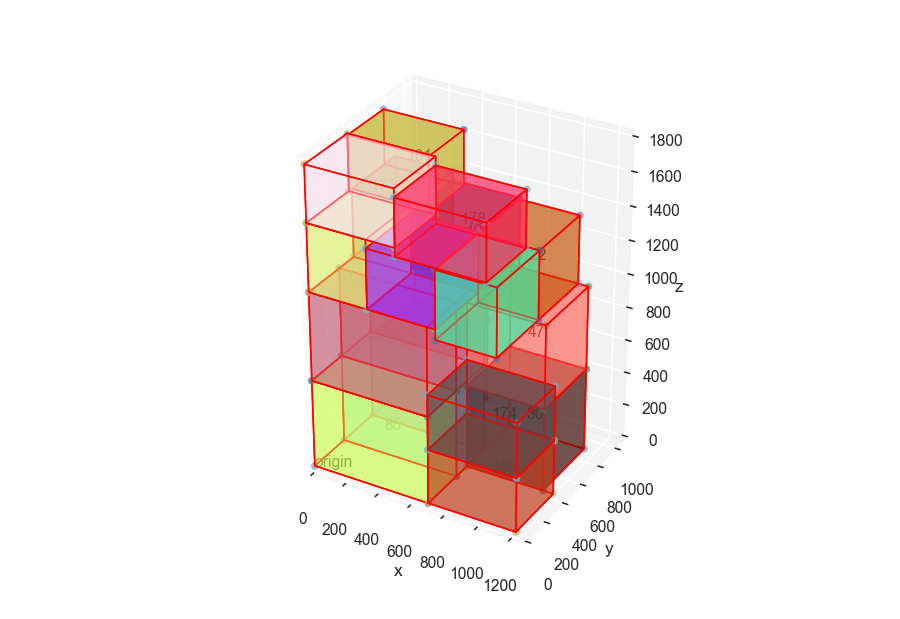

<IPython.core.display.Javascript object>


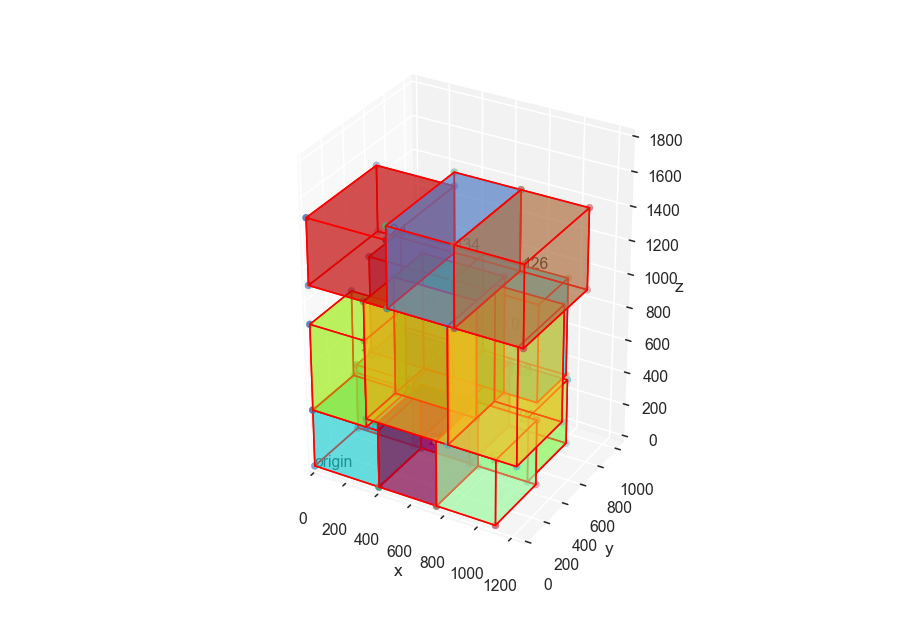

<IPython.core.display.Javascript object>


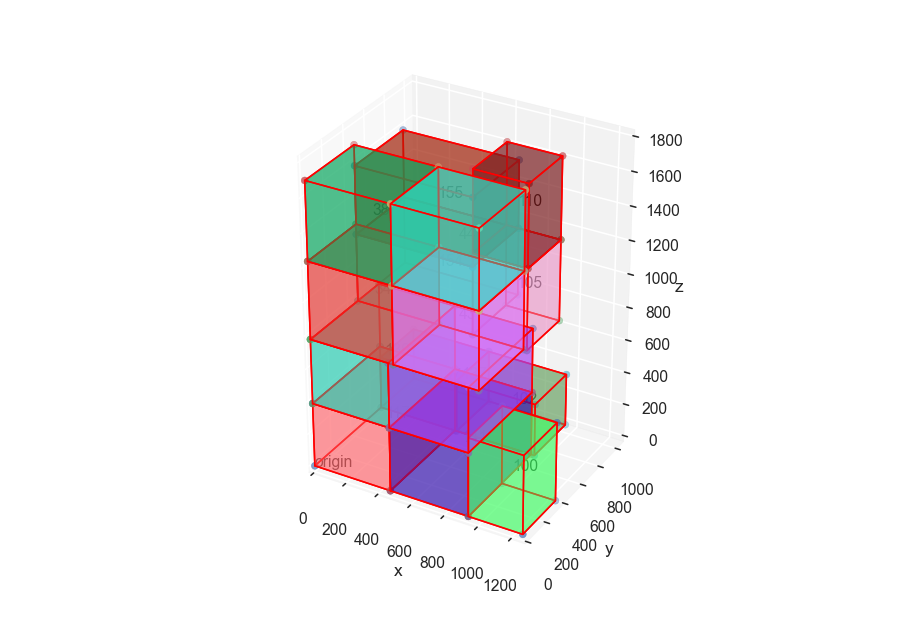

<IPython.core.display.Javascript object>


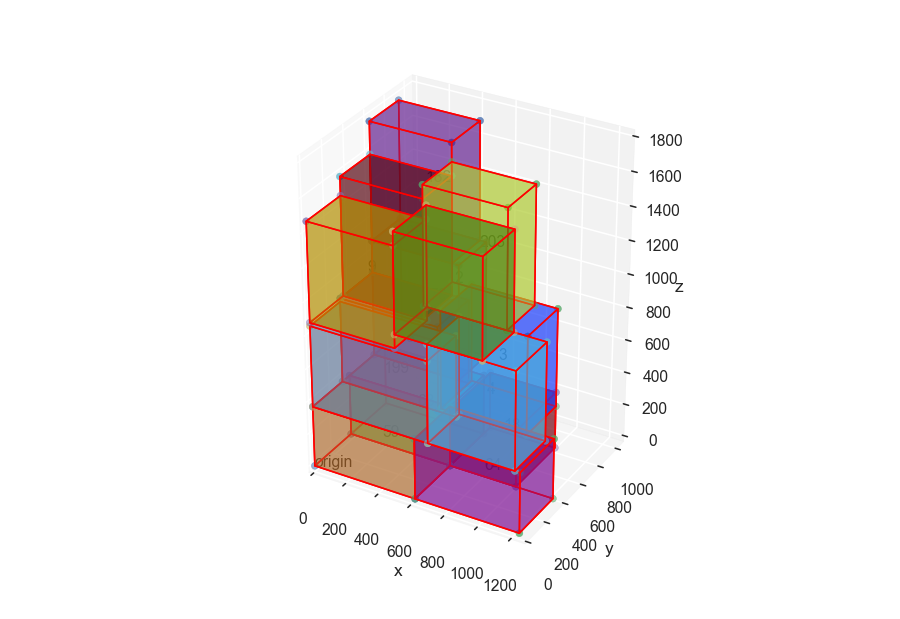

<IPython.core.display.Javascript object>


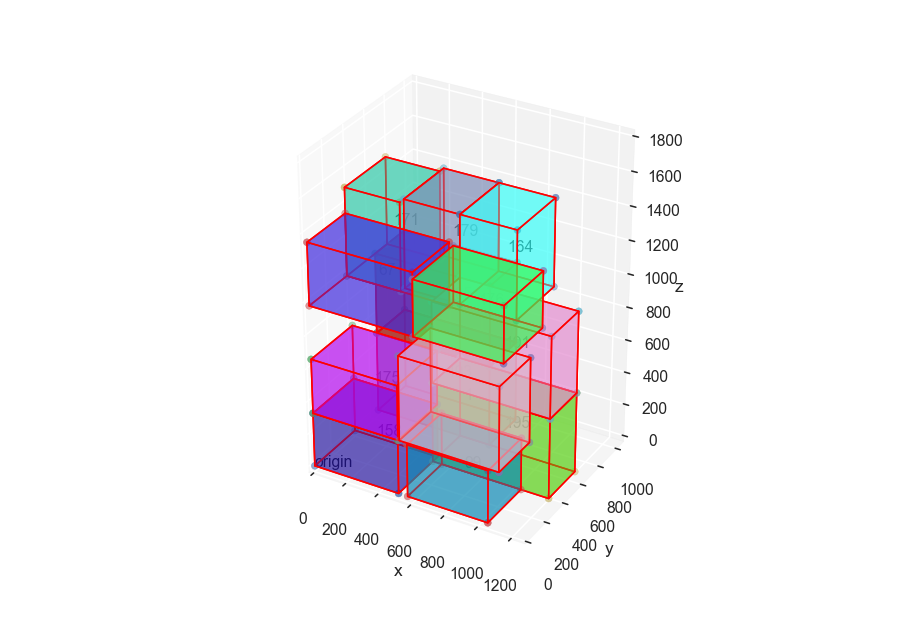

<IPython.core.display.Javascript object>


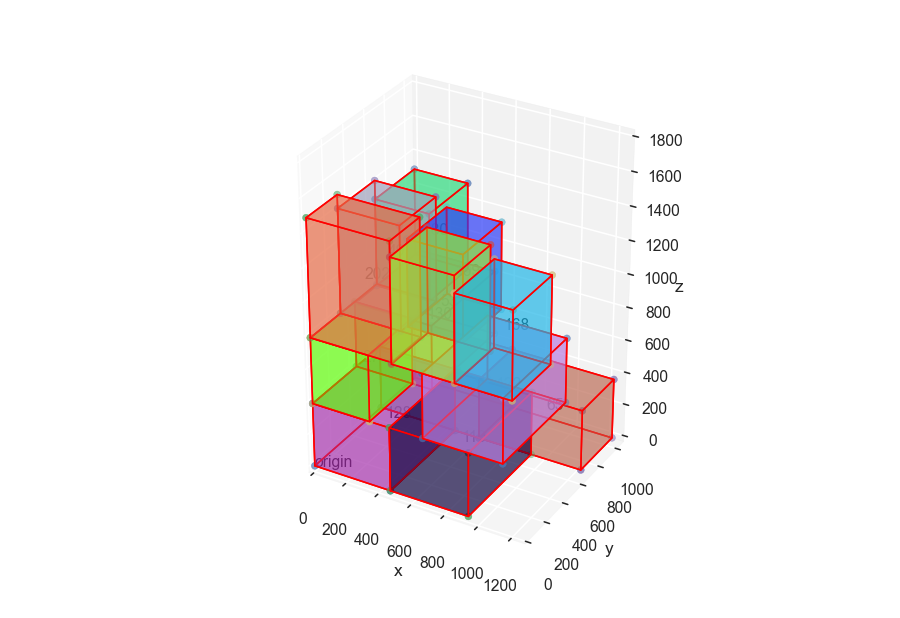

<IPython.core.display.Javascript object>


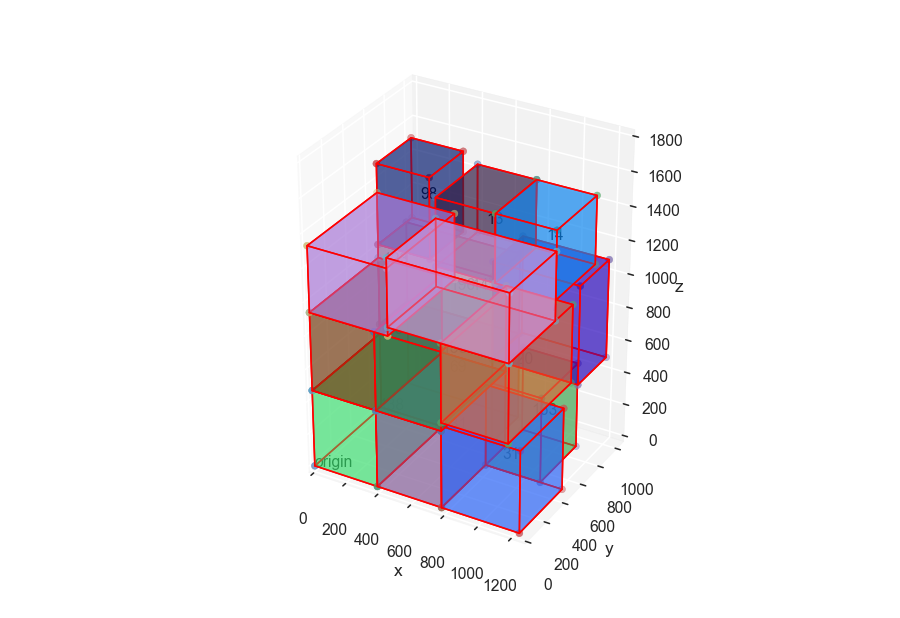

<IPython.core.display.Javascript object>


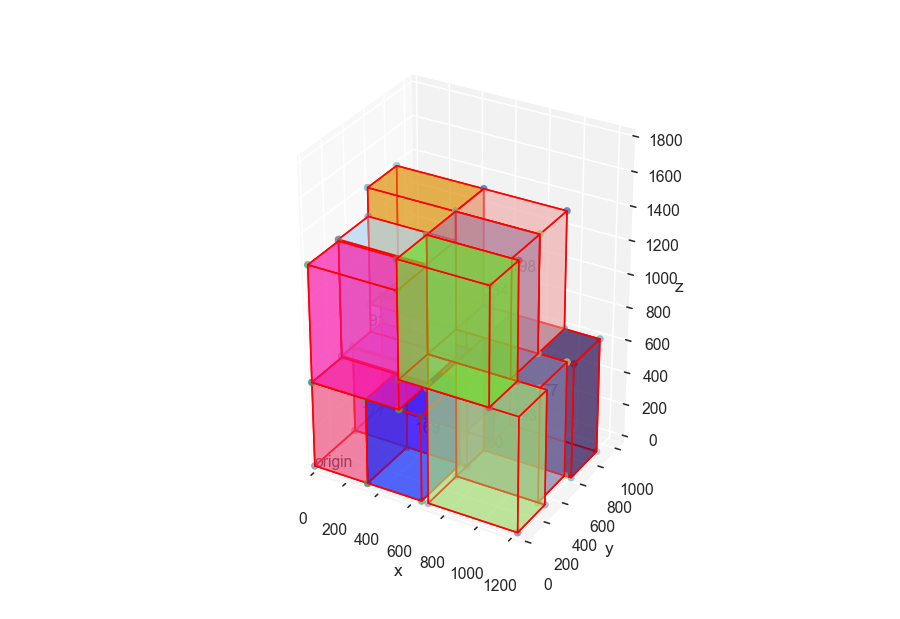

<IPython.core.display.Javascript object>


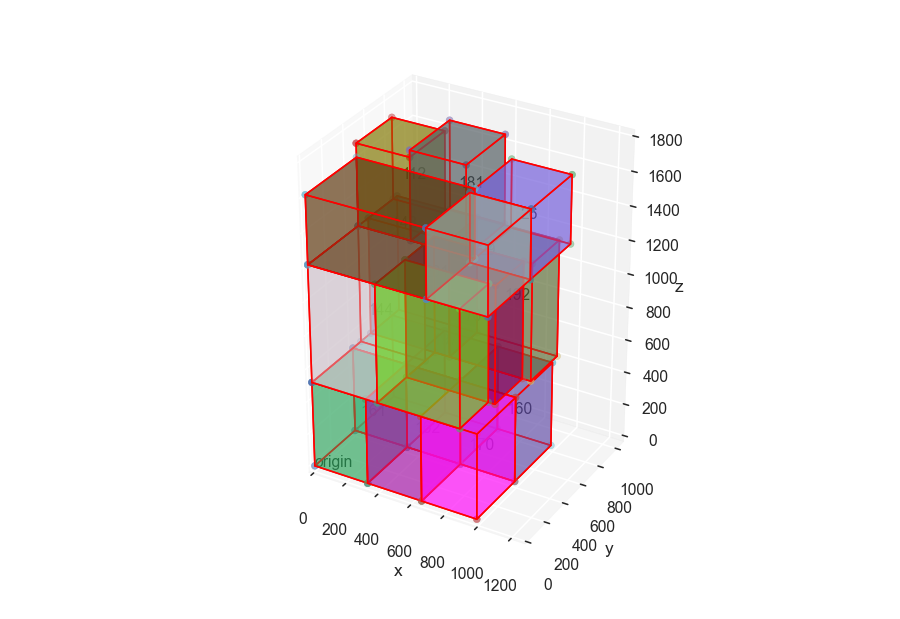

[<Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>]

<IPython.core.display.Javascript object>

In [27]:
bin_pool_ry3.plot()

In [ ]:
bin_ry3_df = bin_pool_ry3.get_original_layer_pool().to_dataframe()
bin_ry3_df.to_csv('bin_ry3_layerResult.csv', index=False)


In [ ]:
bin_ry3_bindf = bin_pool_ry3.get_original_bin_pool().to_dataframe()
bin_ry3_bindf.to_csv("bin_ry3_binResult.csv", index=False)

In [28]:
bin_ry3_bindesdf = bin_pool_ry3.get_original_bin_pool().describe()
bin_ry3_bindesdf.to_csv("bin_ry3_binResultDes.csv", index=False)

<IPython.core.display.Javascript object>

In [ ]:
bin_npt_df = bin_pool_npt.get_original_layer_pool().to_dataframe()
bin_npt_df.to_csv('bin_npt_layerResult.csv', index=False)


In [29]:
bin_npt_bindf = bin_pool_npt.get_original_bin_pool().to_dataframe()
bin_npt_bindf.to_csv("bin_npt_binResult.csv", index=False)

<IPython.core.display.Javascript object>

In [30]:
bin_npt_bindesdf = bin_pool_npt.get_original_bin_pool().describe()
bin_npt_bindesdf.to_csv("bin_npt_binResultDes.csv", index=False)

<IPython.core.display.Javascript object>

In [34]:
bin_ry5_df = bin_pool_ry5.get_original_layer_pool().to_dataframe()
bin_ry5_df.to_csv('bin_ry5_layerResult.csv', index=False)


<IPython.core.display.Javascript object>

In [35]:
bin_ry5_bindf = bin_pool_ry5.get_original_bin_pool().to_dataframe()
bin_ry5_bindf.to_csv("bin_ry5_binResult.csv", index=False)

<IPython.core.display.Javascript object>

In [36]:
bin_ry5_bindesdf = bin_pool_ry5.get_original_bin_pool().describe()
bin_ry5_bindesdf.to_csv("bin_ry5_binResultDes.csv", index=False)

<IPython.core.display.Javascript object>